# Chapter 1 - Introduction (Python Code)

In [9]:
pip install --upgrade quantecon_book_networks kaleido

Note: you may need to restart the kernel to use updated packages.


We begin by importing the `quantecon` package as well as some functions and data that have been packaged for release with this text.

In [10]:
import quantecon as qe
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.data as qbn_data
import quantecon_book_networks.plotting as qbn_plot
ch1_data = qbn_data.introduction()
export_figures = False

In [11]:
quantecon_book_networks.__version__

'0.5'

Next we import some common python libraries.

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
import plotly.graph_objects as go
quantecon_book_networks.config("matplotlib")

## Motivation

### International trade in crude oil 2021

We begin by loading a `NetworkX` directed graph object that represents international trade in crude oil.

In [13]:
DG = ch1_data["crude_oil"]

Next we transform the data to prepare it for display as a Sankey diagram.

In [14]:
nodeid = {}
for ix,nd in enumerate(DG.nodes()):
    nodeid[nd] = ix

# Links
source = []
target = []
value = []
for src,tgt in DG.edges():
    source.append(nodeid[src])
    target.append(nodeid[tgt])
    value.append(DG[src][tgt]['weight'])

Finally we produce our plot.

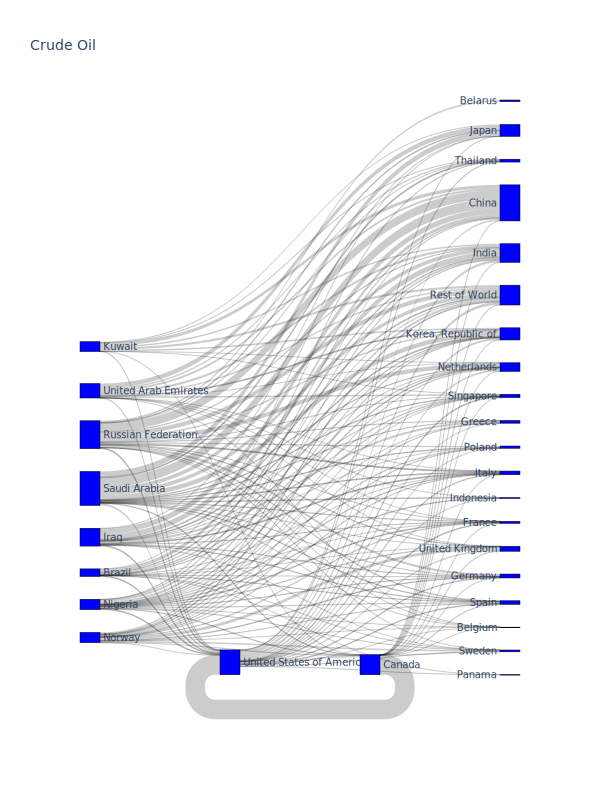

In [15]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(nodeid.keys()),
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])


fig.update_layout(title_text="Crude Oil", font_size=10, width=600, height=800)
if export_figures:
    fig.write_image("figures/crude_oil_2021.pdf")
fig.show(renderer='svg')

### International trade in commercial aircraft during 2019

For this plot we will use a cleaned dataset from 
[Harvard, CID Dataverse](https://dataverse.harvard.edu/dataverse/atlas).

In [16]:
DG = ch1_data['aircraft_network_2019']
pos = ch1_data['aircraft_network_2019_pos']

We begin by calculating some features of our graph using the `NetworkX` and
the `quantecon_book_networks` packages.

In [17]:
centrality = nx.eigenvector_centrality(DG)
node_total_exports = qbn_io.node_total_exports(DG)
edge_weights = qbn_io.edge_weights(DG)

Now we convert our graph features to plot features.

In [18]:
node_pos_dict = pos

node_sizes = qbn_io.normalise_weights(node_total_exports,10000)
edge_widths = qbn_io.normalise_weights(edge_weights,10)

node_colors = qbn_io.colorise_weights(list(centrality.values()),color_palette=cm.viridis)
node_to_color = dict(zip(DG.nodes,node_colors))
edge_colors = []
for src,_ in DG.edges:
    edge_colors.append(node_to_color[src])

Finally we produce the plot.

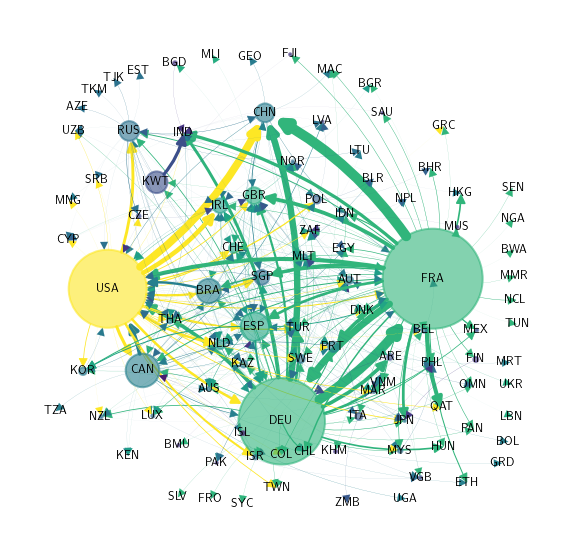

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

nx.draw_networkx_nodes(DG, 
                        node_pos_dict, 
                        node_color=node_colors, 
                        node_size=node_sizes, 
                        linewidths=2, 
                        alpha=0.6, 
                        ax=ax)

nx.draw_networkx_labels(DG, 
                        node_pos_dict,  
                        ax=ax)

nx.draw_networkx_edges(DG, 
                        node_pos_dict, 
                        edge_color=edge_colors, 
                        width=edge_widths, 
                        arrows=True, 
                        arrowsize=20,  
                        ax=ax,
                        node_size=node_sizes, 
                        connectionstyle='arc3,rad=0.15')

if export_figures:
    plt.savefig("figures/commercial_aircraft_2019_1.pdf")
plt.show()

## Spectral Theory

### Spectral Radii

Here we provide code for computing the spectral radius of a matrix.

In [20]:
def spec_rad(M):
    """
    Compute the spectral radius of M.
    """
    return np.max(np.abs(np.linalg.eigvals(M)))

In [21]:
M = np.array([[1,2],[2,1]])
spec_rad(M)

3.0000000000000004

This function is available in the `quantecon_book_networks` package, along with 
several other functions for used repeatedly in the text.  Source code for
these functions can be seen [here](pkg_funcs).

In [22]:
qbn_io.spec_rad(M)

3.0000000000000004

## Probability

### The unit simplex in $\mathbb{R}^3$

Here we define a function for plotting the unit simplex.

In [23]:
def unit_simplex(angle):
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    vtx = [[0, 0, 1],
           [0, 1, 0], 
           [1, 0, 0]]
    
    tri = Poly3DCollection([vtx], color='darkblue', alpha=0.3)
    tri.set_facecolor([0.5, 0.5, 1])
    ax.add_collection3d(tri)

    ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1), 
           xticks=(1,), yticks=(1,), zticks=(1,))

    ax.set_xticklabels(['$(1, 0, 0)$'], fontsize=16)
    ax.set_yticklabels([f'$(0, 1, 0)$'], fontsize=16)
    ax.set_zticklabels([f'$(0, 0, 1)$'], fontsize=16)

    ax.xaxis.majorTicks[0].set_pad(15)
    ax.yaxis.majorTicks[0].set_pad(15)
    ax.zaxis.majorTicks[0].set_pad(35)

    ax.view_init(30, angle)

    # Move axis to origin
    ax.xaxis._axinfo['juggled'] = (0, 0, 0)
    ax.yaxis._axinfo['juggled'] = (1, 1, 1)
    ax.zaxis._axinfo['juggled'] = (2, 2, 0)
    
    ax.grid(False) 
    
    return ax

We can now produce the plot.

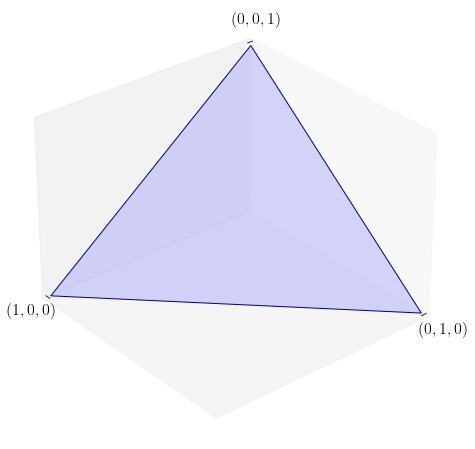

In [24]:
unit_simplex(50)
if export_figures:
    plt.savefig("figures/simplex_1.pdf")
plt.show()

### Independent draws from Student’s t and Normal distributions

Here we illustrate the occurrence of "extreme" events in heavy tailed distributions. 
We start by generating 1,000 samples from a normal distribution and a Student's t distribution.

In [25]:
from scipy.stats import t
n = 1000
np.random.seed(123)

s = 2
n_data = np.random.randn(n) * s

t_dist = t(df=1.5)
t_data = t_dist.rvs(n)

When we plot our samples, we see the Student's t distribution frequently
generates samples many standard deviations from the mean.

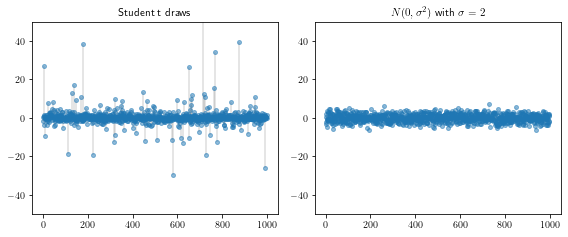

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.4))

for ax in axes:
    ax.set_ylim((-50, 50))
    ax.plot((0, n), (0, 0), 'k-', lw=0.3)

ax = axes[0]
ax.plot(list(range(n)), t_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, t_data, 'k', lw=0.2)
ax.set_title(f"Student t draws", fontsize=11)

ax = axes[1]
ax.plot(list(range(n)), n_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, n_data, lw=0.2)
ax.set_title(f"$N(0, \sigma^2)$ with $\sigma = {s}$", fontsize=11)

plt.tight_layout()
if export_figures:
    plt.savefig("figures/heavy_tailed_draws.pdf")
plt.show()

### CCDF plots for the Pareto and Exponential distributions

When the Pareto tail property holds, the CCDF is eventually log linear. Here
we illustrates this using a Pareto distribution. For comparison, an exponential
distribution is also shown. First we define our domain and the Pareto and
Exponential distributions.

In [27]:
x = np.linspace(1, 10, 500)

In [28]:
α = 1.5
def Gp(x):
    return x**(-α)

In [29]:
λ = 1.0
def Ge(x):
    return np.exp(-λ * x)

We then plot our distribution on a log-log scale.

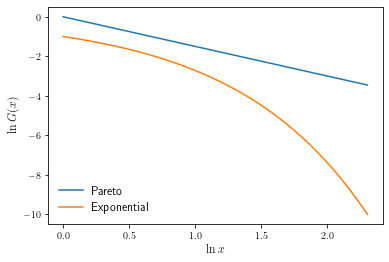

In [30]:
fig, ax = plt.subplots()

ax.plot(np.log(x), np.log(Gp(x)), label="Pareto")
ax.plot(np.log(x), np.log(Ge(x)), label="Exponential")

ax.legend(fontsize=12, frameon=False, loc="lower left")
ax.set_xlabel("$\ln x$", fontsize=12)
ax.set_ylabel("$\ln G(x)$", fontsize=12)

if export_figures:
    plt.savefig("figures/ccdf_comparison_1.pdf")
plt.show()

### Empirical CCDF plots for largest firms (Forbes)

Here we show that the distribution of firm sizes has a Pareto tail. We start
by loading the `forbes_global_2000` dataset.

In [31]:
dfff = ch1_data['forbes_global_2000']

We calculate values of the empirical CCDF.

In [32]:
data = np.asarray(dfff['Market Value'])[0:500]
y_vals = np.empty_like(data, dtype='float64')
n = len(data)
for i, d in enumerate(data):
    # record fraction of sample above d
    y_vals[i] = np.sum(data >= d) / n

Now we fit a linear trend line (on the log-log scale).

In [33]:
x, y = np.log(data), np.log(y_vals)
results = sm.OLS(y, sm.add_constant(x)).fit()
b, a = results.params

Finally we produce our plot.

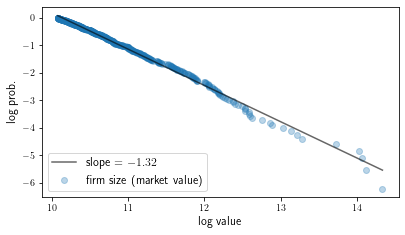

In [34]:
fig, ax = plt.subplots(figsize=(6.4, 3.5))

ax.scatter(x, y, alpha=0.3, label="firm size (market value)")
ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"slope = ${a: 1.2f}$")

ax.set_xlabel('log value', fontsize=12)
ax.set_ylabel("log prob.", fontsize=12)
ax.legend(loc='lower left', fontsize=12)
    
if export_figures:
    plt.savefig("figures/empirical_powerlaw_plots_firms_forbes.pdf")
plt.show()

## Graph Theory

### Zeta and Pareto distributions

We begin by defining the Zeta and Pareto distributions.

In [35]:
γ = 2.0
α = γ - 1

In [36]:
def z(k, c=2.0):
    return c * k**(-γ)

k_grid = np.arange(1, 10+1)

In [37]:
def p(x, c=2.0):
    return c * x**(-γ)

x_grid = np.linspace(1, 10, 200)

Then we can produce our plot

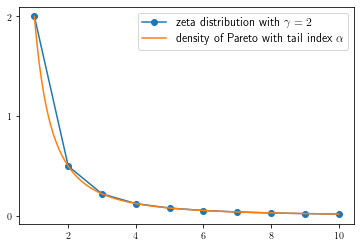

In [38]:
fig, ax = plt.subplots()
ax.plot(k_grid, z(k_grid), '-o', label='zeta distribution with $\gamma=2$')
ax.plot(x_grid, p(x_grid), label='density of Pareto with tail index $\\alpha$')
ax.legend(fontsize=12)
ax.set_yticks((0, 1, 2))
if export_figures:
    plt.savefig("figures/zeta_1.pdf")
plt.show()

### NetworkX digraph plot

We start by creating a graph object and populating it with edges.

In [39]:
G_p = nx.DiGraph()

edge_list = [
    ('p', 'p'),
    ('m', 'p'), ('m', 'm'), ('m', 'r'),
    ('r', 'p'), ('r', 'm'), ('r', 'r')
]

for e in edge_list:
    u, v = e
    G_p.add_edge(u, v)

Now we can plot our graph.

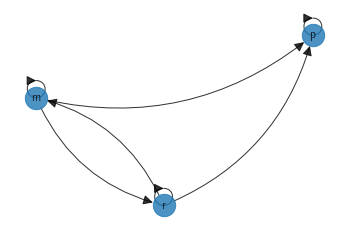

In [40]:
fig, ax = plt.subplots()
nx.spring_layout(G_p, seed=4)
nx.draw_spring(G_p, ax=ax, node_size=500, with_labels=True, 
                 font_weight='bold', arrows=True, alpha=0.8,
                 connectionstyle='arc3,rad=0.25', arrowsize=20)
if export_figures:
    plt.savefig("figures/networkx_basics_1.pdf")
plt.show()

The `DiGraph` object has methods that calculate in-degree and out-degree of vertices.

In [41]:
G_p.in_degree('p')

3

In [42]:
G_p.out_degree('p')

1

Additionally, the `NetworkX` package supplies functions for testing
communication and strong connectedness, as well as to compute strongly
connected components.

In [43]:
G = nx.DiGraph()
G.add_edge(1, 1)
G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(3, 2)
list(nx.strongly_connected_components(G))

[{1}, {2, 3}]

Like `NetworkX`, the QuantEcon Python library `quantecon` supplies a graph
object that implements certain graph-theoretic algorithms. 

The set of available algorithms is more limited but each one is faster, accelerated by
just-in-time compilation. 

In the case of QuantEcon's `DiGraph` object, an instance is created via the adjacency matrix.

In [44]:
A = ((1, 0, 0),
     (1, 1, 1),
     (1, 1, 1))
A = np.array(A) # Convert to NumPy array
G = qe.DiGraph(A)

G.strongly_connected_components

[array([0]), array([1, 2])]

### International private credit flows by country

We begin by loading an adjacency matrix of international private credit flows
(in the form of a NumPy array and a list of country labels).

In [45]:
Z = ch1_data["adjacency_matrix_2022"]["Z"]
Z_visual= ch1_data["adjacency_matrix_2022"]["Z_visual"]
countries = ch1_data["adjacency_matrix_2022"]["countries"]

To calculate our graph's properties, we use hub-based eigenvector
centrality as our centrality measure for this plot.

In [46]:
centrality = qbn_io.eigenvector_centrality(Z_visual, authority=False)

Now we convert our graph features to plot features.

In [47]:
node_colors = cm.plasma(qbn_io.to_zero_one_beta(centrality))

Finally we produce the plot.

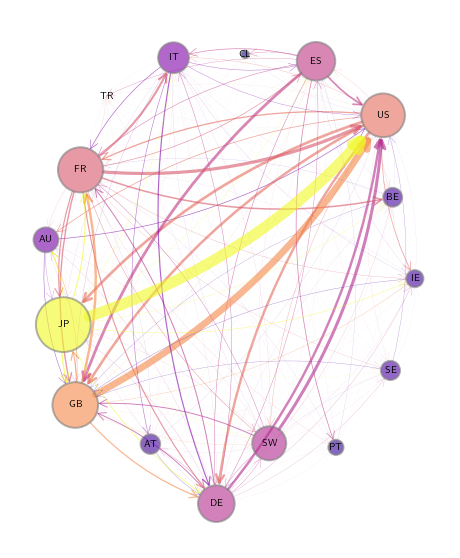

In [48]:
X = qbn_io.to_zero_one_beta(Z.sum(axis=1))

fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")

qbn_plot.plot_graph(Z_visual, X, ax, countries,
           layout_type='spring',
           layout_seed=1234,
           node_size_multiple=3000,
           edge_size_multiple=0.000006,
           tol=0.0,
           node_color_list=node_colors) 

if export_figures:
    plt.savefig("figures/financial_network_analysis_visualization.pdf")
plt.show()

### Centrality measures for the credit network

This figure looks at six different centrality measures.

We begin by defining a function for calculating eigenvector centrality.

Hub-based centrality is calculated by default, although authority-based centrality
can be calculated by setting `authority=True`.

In [49]:
def eigenvector_centrality(A, k=40, authority=False):
    """
    Computes the dominant eigenvector of A. Assumes A is 
    primitive and uses the power method.  
    
    """
    A_temp = A.T if authority else A
    n = len(A_temp)
    r = spec_rad(A_temp)
    e = r**(-k) * (np.linalg.matrix_power(A_temp, k) @ np.ones(n))
    return e / np.sum(e)

Here a similar function is defined for calculating Katz centrality.

In [153]:
def katz_centrality(A, b=1, authority=False):
    """
    Computes the Katz centrality of A, defined as the x solving

    x = 1 + b A x    (1 = vector of ones)

    Assumes that A is square.

    If authority=True, then A is replaced by its transpose.
    """
    n = len(A)
    I = np.identity(n)
    C = I - b * A.T if authority else I - b * A
    if np.linalg.det(C) <= 0 :
        print("non") 
    return np.linalg.solve(C, np.ones(n))

Now we generate an unweighted version of our matrix to help calculate in-degree and out-degree.

In [51]:
D = qbn_io.build_unweighted_matrix(Z)

We now use the above to calculate the six centrality measures.

In [154]:
outdegree = D.sum(axis=1)
ecentral_hub = eigenvector_centrality(Z, authority=False)
kcentral_hub = katz_centrality(Z, b=1/1_700_000)

indegree = D.sum(axis=0)
ecentral_authority = eigenvector_centrality(Z, authority=True)
kcentral_authority = katz_centrality(Z, b=1/1_700_000, authority=True)

Here we provide a helper function that returns a DataFrame for each measure.
The DataFrame is ordered by that measure and contains color information.

In [155]:
def centrality_plot_data(countries, centrality_measures):
    df = pd.DataFrame({'code': countries,
                       'centrality':centrality_measures, 
                       'color': qbn_io.colorise_weights(centrality_measures).tolist()
                       })
    return df.sort_values('centrality')

Finally, we plot the various centrality measures.

In [54]:
from icecream import ic

ic| df:    code  centrality                                color
        3    TR    1.224931  [0.050383, 0.029803, 0.527975, 1.0]
        1    CL    1.307169  [0.115124, 0.023556, 0.555468, 1.0]
        2    PT    1.623419  [0.186213, 0.018803, 0.587228, 1.0]
        5    AT    2.487562  [0.267703, 0.012716, 0.620346, 1.0]
        12   IE    2.514240  [0.267703, 0.012716, 0.620346, 1.0]
        6    BE    2.635970  [0.274191, 0.012109, 0.622722, 1.0]
        15   SE    3.020184  [0.299855, 0.009561, 0.631624, 1.0]
        0    AU    6.790654  [0.459623, 0.003574, 0.660277, 1.0]
        13   IT    8.318096  [0.506454, 0.016333, 0.656202, 1.0]
        7    SW   16.861760   [0.69284, 0.165141, 0.564522, 1.0]
        8    DE   17.925385  [0.710549, 0.182868, 0.550004, 1.0]
        9    ES   20.320187  [0.744232, 0.218288, 0.520524, 1.0]
        10   FR   28.241333  [0.850066, 0.347048, 0.417153, 1.0]
        4    US   32.577850  [0.898984, 0.420392, 0.363047, 1.0]
        11   GB   38.0310

<BarContainer object of 16 artists>

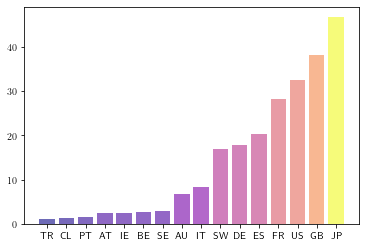

In [146]:
df = centrality_plot_data(countries, kcentral_hub)
ic(df)
fig, ax = plt.subplots()
ax.bar('code', 'centrality', data=df, color=df["color"], alpha=0.6)
# patch = mpatches.Patch(color=None, label='Katz hub', visible=False)
# ax.legend(handles=[patch], fontsize=12, loc="upper left", handlelength=0, frameon=False)


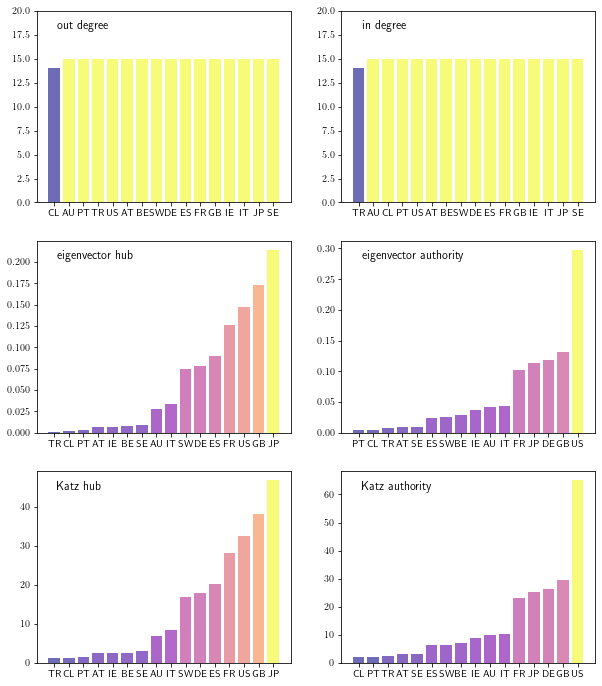

In [157]:
centrality_measures = [outdegree, indegree, 
                       ecentral_hub, ecentral_authority, 
                       kcentral_hub, kcentral_authority]

ylabels = ['out degree', 'in degree',
           'eigenvector hub','eigenvector authority', 
           'Katz hub', 'Katz authority']

ylims = [(0, 20), (0, 20), 
         None, None,   
         None, None]


fig, axes = plt.subplots(3, 2, figsize=(10, 12))

axes = axes.flatten()

for i, ax in enumerate(axes):
    df = centrality_plot_data(countries, centrality_measures[i])
      
    ax.bar('code', 'centrality', data=df, color=df["color"], alpha=0.6)
    
    patch = mpatches.Patch(color=None, label=ylabels[i], visible=False)
    ax.legend(handles=[patch], fontsize=12, loc="upper left", handlelength=0, frameon=False)
    
    if ylims[i] is not None:
        ax.set_ylim(ylims[i])

if export_figures:
    plt.savefig("figures/financial_network_analysis_centrality.pdf")
plt.show()

### Computing in and out degree distributions

The in-degree distribution evaluated at $k$ is the fraction of nodes in a
network that have in-degree $k$. The in-degree distribution of a `NetworkX`
DiGraph can be calculated using the code below.

In [58]:
def in_degree_dist(G):
    n = G.number_of_nodes()
    iG = np.array([G.in_degree(v) for v in G.nodes()])
    d = [np.mean(iG == k) for k in range(n+1)]
    return d

The out-degree distribution is defined analogously.

In [59]:
def out_degree_dist(G):
    n = G.number_of_nodes()
    oG = np.array([G.out_degree(v) for v in G.nodes()])
    d = [np.mean(oG == k) for k in range(n+1)]
    return d

### Degree distribution for international aircraft trade

Here we illustrate that the commercial aircraft international trade network is
approximately scale-free by plotting the degree distribution alongside
$f(x)=cx-\gamma$ with $c=0.2$ and $\gamma=1.1$. 

In this calculation of the degree distribution, performed by the NetworkX
function `degree_histogram`, directions are ignored and the network is treated
as an undirected graph.

In [60]:
def plot_degree_dist(G, ax, loglog=True, label=None):
    "Plot the degree distribution of a graph G on axis ax."
    dd = [x for x in nx.degree_histogram(G) if x > 0]
    dd = np.array(dd) / np.sum(dd)  # normalize
    if loglog:
        ax.loglog(dd, '-o', lw=0.5, label=label)
    else:
        ax.plot(dd, '-o', lw=0.5, label=label)

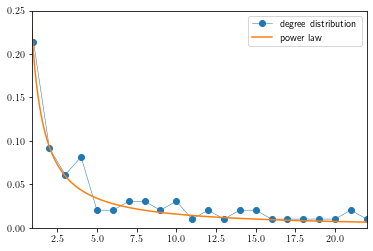

In [61]:
fig, ax = plt.subplots()

plot_degree_dist(DG, ax, loglog=False, label='degree distribution')

xg = np.linspace(0.5, 25, 250)
ax.plot(xg, 0.2 * xg**(-1.1), label='power law')
ax.set_xlim(0.9, 22)
ax.set_ylim(0, 0.25)
ax.legend()
if export_figures:
    plt.savefig("figures/commercial_aircraft_2019_2.pdf")
plt.show()

### Random graphs

The code to produce the Erdos-Renyi random graph, used below, applies the
combinations function from the `itertools` library. The function
`combinations(A, k)` returns a list of all subsets of $A$ of size $k$. For
example:

In [62]:
import itertools
letters = 'a', 'b', 'c'
list(itertools.combinations(letters, 2))

[('a', 'b'), ('a', 'c'), ('b', 'c')]

Below we generate random graphs using the Erdos-Renyi and Barabasi-Albert
algorithms. Here, for convenience, we will define a function to plot these
graphs.

In [63]:
def plot_random_graph(RG,ax):
    node_pos_dict = nx.spring_layout(RG, k=1.1)

    centrality = nx.degree_centrality(RG)
    node_color_list = qbn_io.colorise_weights(list(centrality.values()))

    edge_color_list = []
    for i in range(n):
        for j in range(n):
            edge_color_list.append(node_color_list[i])

    nx.draw_networkx_nodes(RG, 
                           node_pos_dict, 
                           node_color=node_color_list, 
                           edgecolors='grey', 
                           node_size=100,
                           linewidths=2, 
                           alpha=0.8, 
                           ax=ax)

    nx.draw_networkx_edges(RG, 
                           node_pos_dict, 
                           edge_color=edge_colors, 
                           alpha=0.4,  
                           ax=ax)

### An instance of an Erdos–Renyi random graph

In [64]:
n = 100
p = 0.05
G_er = qbn_io.erdos_renyi_graph(n, p, seed=1234)

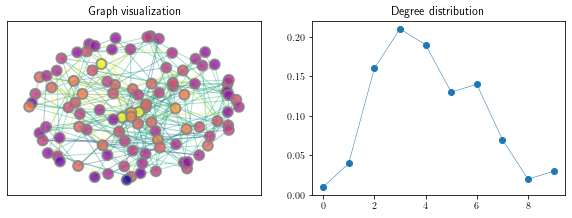

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.2))

axes[0].set_title("Graph visualization")
plot_random_graph(G_er,axes[0])

axes[1].set_title("Degree distribution")
plot_degree_dist(G_er, axes[1], loglog=False)

if export_figures:
    plt.savefig("figures/rand_graph_experiments_1.pdf")
plt.show()

### An instance of a preferential attachment random graph

In [66]:
n = 100
m = 5
G_ba = nx.generators.random_graphs.barabasi_albert_graph(n, m, seed=123)

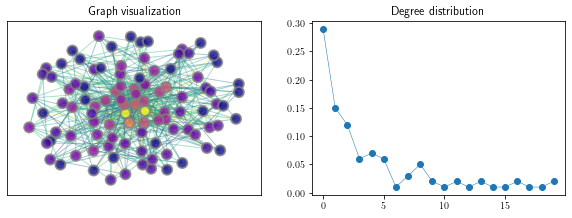

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.2))

axes[0].set_title("Graph visualization")
plot_random_graph(G_ba, axes[0])

axes[1].set_title("Degree distribution")
plot_degree_dist(G_ba, axes[1], loglog=False)

if export_figures:
    plt.savefig("figures/rand_graph_experiments_2.pdf")
plt.show()